# Regional SWMT for ACCESS-OM2 (prescribed)

In [1]:
import intake
import glob
from pathlib import Path
import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
import dask.distributed
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import pdb
import os
import pathlib
import shutil

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39935/status,
Dashboard: /proxy/39935/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36187,Workers: 0
Dashboard: /proxy/39935/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35061,Total threads: 1
Dashboard: /proxy/34807/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38579,


### Importing data

In [3]:
lat_slice = slice(None, -59)

path_to_ocean_static = Path('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean_grid.nc')
grid = xr.open_dataset(path_to_ocean_static)

depth = grid['ht'].sel(yt_ocean=lat_slice)
area_old = grid['area_t'].sel(yt_ocean=lat_slice)
varr = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean.nc')['salt'].sel(yt_ocean=lat_slice).isel(time=0,st_ocean=0)
land_mask = (0 * depth).fillna(1)

In [4]:
# Correcting area
area_corr = (area_old*(varr*0+1))
area_corr = area_corr.drop_vars(['time','st_ocean']).squeeze()

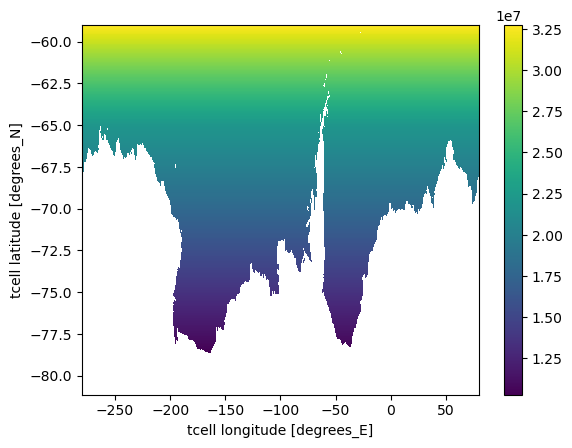

In [5]:
area_corr.plot()

In [6]:
# Importing the saved files
salt_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/binned_salt_trans_access_C_*'))
heat_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/binned_heat_trans_access_C_*'))

salt_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/binned_salt_trans_access_M_*'))
heat_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/binned_heat_trans_access_M_*'))

In [7]:
salt_tr_C = xr.open_mfdataset(salt_files_C, concat_dim='time', combine='nested', chunks={'time': 1, 'yt_ocean': 100, 'xt_ocean': 100})
heat_tr_C = xr.open_mfdataset(heat_files_C, concat_dim='time', combine='nested', chunks={'time': 1, 'yt_ocean': 100, 'xt_ocean': 100})
salt_tr_C = salt_tr_C.to_array().squeeze()
heat_tr_C = heat_tr_C.to_array().squeeze()

In [8]:
salt_tr_M = xr.open_mfdataset(salt_files_M, concat_dim='time', combine='nested', chunks={'time': 1, 'yt_ocean': 100, 'xt_ocean': 100})
heat_tr_M = xr.open_mfdataset(heat_files_M, concat_dim='time', combine='nested', chunks={'time': 1, 'yt_ocean': 100, 'xt_ocean': 100})
salt_tr_M = salt_tr_M.to_array().squeeze()
heat_tr_M = heat_tr_M.to_array().squeeze()

In [9]:
net_tr_C = salt_tr_C + heat_tr_C
net_tr_M = salt_tr_M + heat_tr_M

Defining shelf and land masks.

In [10]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [11]:
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

### Regional sub sections

In [12]:
xt_ocean = grid['xt_ocean']
yt_ocean = grid['yt_ocean']

In [13]:
def mask_from_polygon(lon, lat, xt_ocean, yt_ocean):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xt_ocean, yt_ocean)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xt_ocean.size, yt_ocean.size).transpose()
    mask = xr.DataArray(
    mask, dims=['yt_ocean', 'xt_ocean'],
    coords={'xt_ocean': xt_ocean, 'yt_ocean': yt_ocean})
    return mask

In [14]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]]}


In [16]:
mask_list = []

for a, area_text in enumerate(DSW_region['name']):
    mask_single = mask_from_polygon(
        DSW_region['lon'][a], DSW_region['lat'][a],
        xt_ocean, yt_ocean
    )
    # apply shelf mask while still 2D
    mask_single, shelf_mask = shelf_mask_isobath(mask_single, 'mom5')

    mask_list.append(mask_single.expand_dims(area=[area_text]))

mask_DSW = xr.concat(mask_list, dim="area")

# cleanup
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW.where(mask_DSW == 1, 0)


In [17]:
mask_DSW.sel(area="Adelie")

<xarray.DataArray (yt_ocean: 510, xt_ocean: 3600)> Size: 15MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    area      <U6 24B 'Adelie'
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03

In [18]:
# Defining formation region areas
area_Adelie = area_corr.where(mask_DSW.sel(area="Adelie") == 1)
area_Ross = area_corr.where(mask_DSW.sel(area="Ross") == 1)
area_Weddell = area_corr.where(mask_DSW.sel(area="Weddell") == 1)
area_Prydz = area_corr.where(mask_DSW.sel(area="Prydz") == 1)


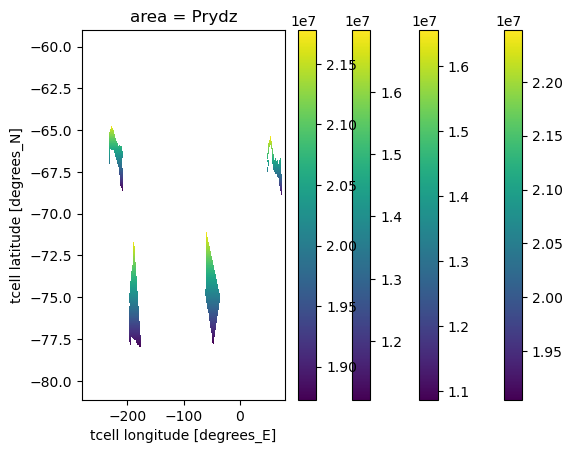

In [19]:
area_Adelie.plot()
area_Ross.plot()
area_Weddell.plot()
area_Prydz.plot()

### Redo below four times for each section:

In [53]:
swmt_shelf_C = (net_tr_C * area_Ross / 1e6)
heat_shelf_C = (heat_tr_C * area_Ross / 1e6)
salt_shelf_C = (salt_tr_C * area_Ross / 1e6)

swmt_shelf_sum_C = swmt_shelf_C.cf.sum(['longitude', 'latitude'])
heat_shelf_sum_C = heat_shelf_C.cf.sum(['longitude', 'latitude'])
salt_shelf_sum_C = salt_shelf_C.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum_C, heat_shelf_sum_C, salt_shelf_sum_C]:
    da.attrs["units"] = "Sv"

In [54]:
swmt_shelf_sum_C

<xarray.DataArray (time: 10, isopycnal_bins: 129)> Size: 10kB
dask.array<sum-aggregate, shape=(10, 129), dtype=float64, chunksize=(1, 129), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1kB 25.02 25.08 ... 28.45 28.47
    st_ocean        float64 8B 0.5413
    area            <U4 16B 'Ross'
Dimensions without coordinates: time
Attributes:
    units:    Sv

In [55]:
swmt_shelf_sum_C = swmt_shelf_sum_C.compute()

In [56]:
swmt_shelf_sum_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/plots/swmt_shelf_sum_C_form_Ross_prescribed_access.nc')

In [57]:
swmt_shelf_M = (net_tr_M * area_Ross / 1e6)
heat_shelf_M = (heat_tr_M * area_Ross / 1e6)
salt_shelf_M = (salt_tr_M * area_Ross / 1e6)
swmt_shelf_sum_M = swmt_shelf_M.cf.sum(['longitude', 'latitude'])
heat_shelf_sum_M = heat_shelf_M.cf.sum(['longitude', 'latitude'])
salt_shelf_sum_M = salt_shelf_M.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum_M, heat_shelf_sum_M, salt_shelf_sum_M]:
    da.attrs["units"] = "Sv"

In [58]:
swmt_shelf_sum_M = swmt_shelf_sum_M.compute()

In [59]:
swmt_shelf_sum_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/plots/swmt_shelf_sum_M_form_Ross_prescribed_access.nc')

In [60]:
# Time mean
swmt_shelf_sum_ave_C = swmt_shelf_sum_C.mean(dim='time')

for da in [swmt_shelf_sum_ave_C]:
    da.attrs["units"] = "Sv"

In [61]:
# Time mean
swmt_shelf_sum_ave_M = swmt_shelf_sum_M.mean(dim='time')

for da in [swmt_shelf_sum_ave_M]:
    da.attrs["units"] = "Sv"

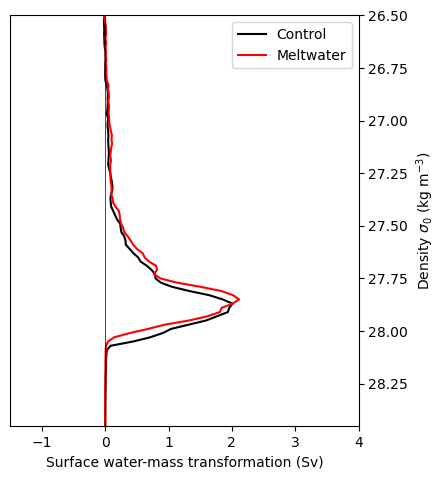

In [62]:
fig, ax1 = plt.subplots(figsize=(4.5, 5.33))

ax1.plot(swmt_shelf_sum_ave_C, swmt_shelf_sum_ave_C['isopycnal_bins'], color = 'k', label='Control')
ax1.plot(swmt_shelf_sum_ave_M, swmt_shelf_sum_ave_M['isopycnal_bins'], color = 'r', label='Meltwater')
ax1.plot([0, 0], [26.5,28.49], 'k', linewidth=0.5)
ax1.set_ylim((28.45, 26.5))
ax1.set_xlim((-1.5, 4))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel('Density $\sigma_0$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();

In [63]:
swmt_shelf_sum_ave_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/plots/swmt_shelf_sum_ave_C_form_Ross_prescribed_access.nc')
swmt_shelf_sum_ave_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_ACCESS_SWMT_shelf_rho0/plots/swmt_shelf_sum_ave_M_form_Ross_prescribed_access.nc')